In [34]:
import numpy as np
import os
import random

import scipy.io as sio

from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers as kl

import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import itertools

from utils import*
import librosa
import librosa.display
from PIL import Image

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

In [35]:
from utils import*
# =============================================================================
# source_dir
# =============================================================================
source_dir= './original_mat/'
# =============================================================================
# load mat files
# =============================================================================
normal_features=sio.loadmat(os.path.join(source_dir,'normal_322.mat')) 
normal_features=normal_features['normal']

crackle_features=sio.loadmat(os.path.join(source_dir,'crackle_322.mat')) 
crackle_features=crackle_features['crackle']

wheeze_features=sio.loadmat(os.path.join(source_dir,'wheeze_322.mat')) 
wheeze_features=wheeze_features['wheeze']

both_features=sio.loadmat(os.path.join(source_dir,'both_322.mat')) 
both_features=both_features['both']    

In [36]:
# label 2, 3 --> 1 for binary classification
wheeze_features[:,-1] = np.ones((3642,))
both_features[:,-1] = np.ones((3642,))
wheeze_features[:,-1]

array([1., 1., 1., ..., 1., 1., 1.])

In [37]:
#X = np.concatenate((normal_features[:,:-1], crackle_features[:,:-1], wheeze_features[:,:-1],both_features[:,:-1]), axis=0)
#y = np.concatenate((normal_features[:,-1],crackle_features[:,-1], wheeze_features[:,-1], both_features[:,-1]), axis=0)
X = np.concatenate((normal_features[:,:-1], crackle_features[:,:-1]), axis=0)
y = np.concatenate((normal_features[:,-1],crackle_features[:,-1]), axis=0)
print(y.shape)
# =============================================================================
# normalization
# =============================================================================
min_max_scaler=MinMaxScaler()
X = min_max_scaler.fit_transform(X)
# =============================================================================
# feature reduction (K-PCA)
# =============================================================================
transformer = KernelPCA(n_components=128, kernel='linear') #30% of 322 = 97
X = transformer.fit_transform(X)

(7284,)


In [38]:
tf.random.set_seed(42)
# Define function to build model with specified random seed
def build_model(feature_size, n_classes, dropout):
    """ Build a small model for multi-label classification """
    inp = kl.Input((feature_size,))
    x = kl.Dense(1024, activation='relu')(inp)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(dropout)(x)
    x = kl.Dense(640, activation='relu')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(dropout)(x)
    x = kl.Dense(512, activation='relu')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(dropout)(x)
    x = kl.Dense(256, activation='relu')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(dropout)(x)
    x = kl.Dense(128, activation='relu')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(dropout)(x)
    x = kl.Dense(64, activation='relu')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(dropout)(x)
    x = kl.Dense(32, activation='relu')(x)
    x = kl.BatchNormalization()(x)
    x = kl.Dropout(dropout)(x)
    if n_classes == 1:
        out = kl.Dense(1, activation='sigmoid')(x)
    else:
        out = kl.Dense(n_classes, activation='softmax')(x)
    #out = kl.Dense(n_classes, activation='softmax')(x) # change softmax
    model = keras.Model(inputs=inp, outputs=out)
    return model

In [39]:
# =============================================================================
# devide data into test,train, and validation sets
# =============================================================================
#y = to_categorical(y)
print('y value: ', y.shape)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)
print('X train - y train:', X_train.shape, y_train.shape)
print('X test - y test:', X_test.shape, y_test.shape)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)# 0.25
print('X train - val', X_train.shape, y_train.shape)

y value:  (7284,)
X train - y train: (4370, 128) (4370,)
X test - y test: (2914, 128) (2914,)
X train - val (3277, 128) (3277,)


In [40]:
# =============================================================================
# build model
# =============================================================================
model = build_model(feature_size=X_train.shape[-1], n_classes=1, dropout= 0.2)
print('Built model!!!', model)
# # =============================================================================
# train model
# =============================================================================
callback = EarlyStopping(monitor='loss', patience=3)
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
#criterion = tf.keras.losses.categorical_crossentropy
criterion = tf.keras.losses.binary_crossentropy
model.compile(optimizer=opt, loss=criterion,metrics=['acc'])
trainedmodel = model.fit(X_train, y_train,batch_size = 128,epochs=100, validation_data = (X_val, y_val), callbacks=[callback])


Built model!!! <Functional name=functional_7, built=True>
Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - acc: 0.5059 - loss: 0.8953 - val_acc: 0.4785 - val_loss: 0.6953
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.5682 - loss: 0.7860 - val_acc: 0.4785 - val_loss: 0.7012
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.5917 - loss: 0.7563 - val_acc: 0.4785 - val_loss: 0.7091
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.5968 - loss: 0.7271 - val_acc: 0.4785 - val_loss: 0.7162
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.5961 - loss: 0.7119 - val_acc: 0.4785 - val_loss: 0.7262
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - acc: 0.6396 - loss: 0.6761 - val_acc: 0.4785 - val_loss: 0.7379
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.6367 - loss: 0.6861 - val_acc: 0.4785 - val_loss: 0.7505
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.6463 - loss: 0.6436 - val_acc: 0.4785 - val_loss: 0.752

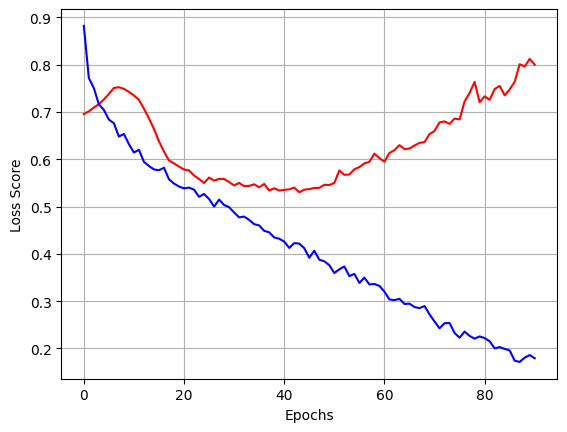

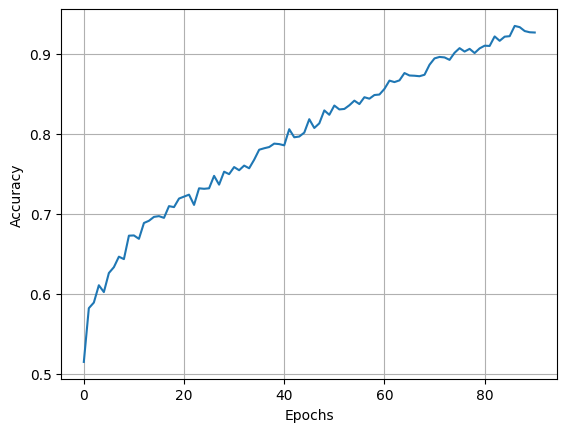

In [41]:
fig = plt.figure()
plt.plot(model.history.history['val_loss'], 'r',model.history.history['loss'], 'b')
plt.xlabel('Epochs')
plt.ylabel('Loss Score')
plt.grid(1)
plt.savefig('training_loss_binary.jpg',dpi=300)


fig = plt.figure()
accuracy = trainedmodel.history['acc']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(1)
plt.savefig('Acc_binary.jpg',dpi=300)

In [26]:
# =============================================================================
# plot confusion matrix
# =============================================================================
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
# =============================================================================
# evaluate model
# =============================================================================
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

print('x test:', X_test.shape)
Y_Score=model.predict(X_test)
print('Y_score:', Y_Score.shape)
#y_pred_ = np.argmax(Y_Score, axis=1)
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print('y test: ', y_test.shape)
# cm=confusion_matrix(np.argmax(y_test, axis=1),y_pred)
# print(cm)

# fig = plt.figure()
# plot_confusion_matrix(cm, classes=['abnormal', 'normal'])
# plt.savefig('conf_matrix.jpg',dpi=300)

test_loss=model.evaluate(X_test,y_test,verbose=1)#evaluate model
print("test_loss:", test_loss)#print test loss and metrics information



x test: (2914, 128)
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Y_score: (2914, 1)
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
y test:  (2914,)
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - acc: 0.7666 - loss: 0.7519
test_loss: [0.767601728439331, 0.7532601356506348]


In [43]:
# =============================================================================
# ROC curve where positive label is abnormal
# =============================================================================
# classes_ = ['','crackle','wheeze','both']
# for pos_label in range(1,4):
#     fpr, tpr, thresholds = roc_curve(y_test[:, pos_label], Y_Score[:, pos_label], pos_label=pos_label)
#     roc_auc = auc(fpr, tpr)
#     fig = plt.figure()
#     plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)\npos_label=%s' % (roc_auc, pos_label))
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver operating characteristic')
#     plt.grid(True)
#     plt.legend(loc="lower right")
#     plt.savefig(f'roc_class_{classes_[pos_label]}.jpg', dpi=300)


# =============================================================================
# ROC curve where positive label is normal
# =============================================================================
# pos_label=0
# fpr, tpr, thresholds = roc_curve(np.argmax(y_test, axis=1), Y_Score[:,pos_label], pos_label=pos_label)
# roc_auc = auc(fpr, tpr)# calculate auc value
# fig = plt.figure()
# plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)\npos_label=Abnormal' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.grid(1)
# plt.legend(loc="lower right")
# plt.savefig('roc_abnormal.jpg',dpi=300)

cm = confusion_matrix(y_test,y_pred)
print('confusion matrix',cm)

# Sensitivity, also known as Recall or True Positive Rate
se = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# Specificity, also known as True Negative Rate
sp = cm[0, 0] / (cm[0, 0] + cm[0, 1])

# Simple average of Sensitivity and Specificity
sc = (se + sp) / 2

# Printing additional metrics for completeness
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Sensitivity Se(normal):', se)
print('Specificity Sp(abnormal):', sp)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('F1 Score:', f1)
print('Score Sc:', sc)

# Classification report
#print(classification_report(y_test, y_pred))


confusion matrix [[1009  426]
 [ 293 1186]]
Specificity Sp: 0.7031358885017421
Sensitivity Se: 0.801893171061528
Accuracy: 0.7532601235415237
Precision: 0.7357320099255583
F1 Score: 0.7673891944354578
Score Sc: 0.7525145297816351


In [1]:
cm

NameError: name 'cm' is not defined